In [6]:
import os
import re
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")

In [11]:
# PATH = "../logs/train_highway_augmenter"
PATH = "../logs/train_highway_augmenter/no_glu_skip_embeddings_over_mask"

ARTICLES_PATH = os.path.join(PATH, "articles.log")
POLARITY_PATH = os.path.join(PATH, "polarity.log")
SMOKERS_PATH = os.path.join(PATH, "smokers.log")

def extract_masking_logs(file):
    best_hparams_line = ''
    # read lines from log
    with open(file) as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]

    # get best model
    for line in reversed(lines):
        if "Finished training model. Best hyperparameters:" in line:
            best_hparams_line = line
            break
    
    assert len(best_hparams_line) > 0, "No best model logs."

    # best model hyperparams in string format
    best_hparams_str = re.findall(r"{.*}", best_hparams_line)[0]

    # find logs of the best model (MUST start with hparam string)
    # find lower line_id
    start_line_id = [i for i in range(len(lines)) if best_hparams_str in lines[i]][0]
    
    # find the end of the experiment (separated by second line of =====)
    end_line_id = start_line_id + [i for i in range(len(lines[start_line_id:])) if '=' * 10 in lines[i+start_line_id]][1]

    best_logs = lines[start_line_id:end_line_id]

    # keep only validation masking ratio
    masked_ratios = [float(line.split()[-1]) for line in best_logs if "end of epoch" in line]

    # check if early stopping was used and remove last 25 epochs
    for line in reversed(lines[start_line_id:end_line_id]):
        if "f1-score has not improved" in line:
            # masked_ratios = masked_ratios[:-24]
            masked_ratios = masked_ratios


    # return json.loads(best_hparams_str.lower().replace("'", '"'))
    return masked_ratios

articles = np.array(extract_masking_logs(ARTICLES_PATH))
polarity = np.array(extract_masking_logs(POLARITY_PATH))
smokers = np.array(extract_masking_logs(SMOKERS_PATH))

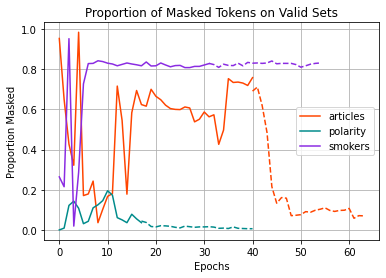

In [12]:
plt.plot(np.arange(len(articles[:-24])), articles[:-24], label="articles", color='orangered', linestyle='-')
plt.plot(np.arange(len(articles[-24:])) + len(articles) - 25, articles[-24:], color='orangered', linestyle='--')

plt.plot(np.arange(len(polarity[:-24])), polarity[:-24], label="polarity", color='darkcyan', linestyle='-')
plt.plot(np.arange(len(polarity[-24:])) + len(polarity) - 25, polarity[-24:], color='darkcyan', linestyle='--')
plt.plot(np.arange(len(smokers[:-24])), smokers[:-24], label="smokers", color='blueviolet', linestyle='-')
plt.plot(np.arange(len(smokers[-24:])) + len(smokers) - 25, smokers[-24:], color='blueviolet', linestyle='--')

# plt.plot(articles, label="articles", color='orangered')
# plt.plot(polarity, label="polarity", color='darkcyan')
# plt.plot(smokers, label="smokers", color='blueviolet')


plt.title("Proportion of Masked Tokens on Valid Sets")
plt.xlabel("Epochs")
plt.ylabel("Proportion Masked")
plt.legend()
plt.grid()
plt.show()